In [86]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

In [87]:
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,
)

(trainData, valData) = random_split(train_data,
	[50000, 10000],
	generator=torch.Generator().manual_seed(42))

In [88]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [89]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [90]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

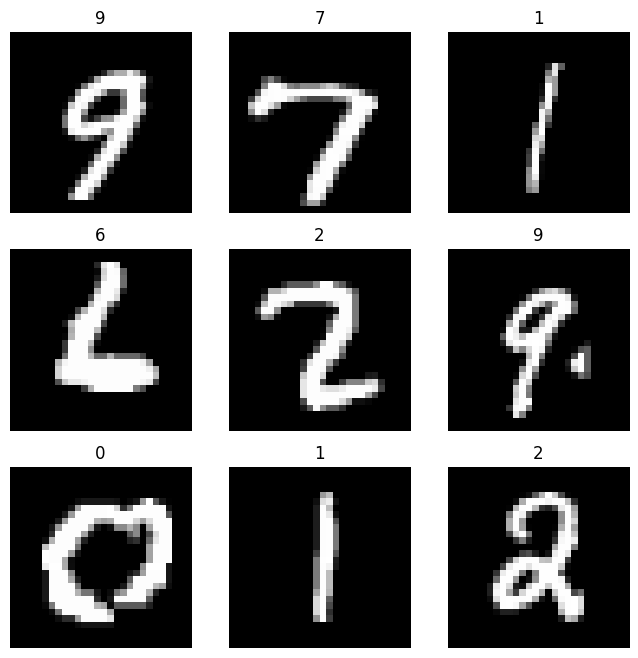

In [91]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [102]:
train_loader = torch.utils.data.DataLoader(trainData, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=128, shuffle=True)

In [95]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn

In [96]:
class MyNetwork(Module):
    def __init__(self, numChannels, classes):
        super(MyNetwork, self).__init__()
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,kernel_size=(4, 4))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = Conv2d(in_channels=20, out_channels=50,kernel_size=(4,4))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3= Conv2d(in_channels=50,out_channels=30,kernel_size=(4,4))
        #self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu3 = ReLU()
        
        
        self.fc1 = Linear(in_features=30, out_features=20)
        self.relu4 = ReLU()
        self.fc2 = Linear(in_features=20, out_features=15)
        self.relu5 = ReLU()
        self.fc3 = Linear(in_features=15, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        #x = self.maxpool3(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu4(x)
        
        x = self.fc2(x)
        x = self.relu5(x)

        x = self.fc3(x)
        output = self.logSoftmax(x)
        return output

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [98]:
model = MyNetwork(numChannels=1,classes=len(trainData.dataset.classes)).to(device)
opt = Adam(model.parameters(), lr=1e-3)
lossFn = nn.NLLLoss()

In [99]:
hist = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

In [121]:
model.to(device)
for e in range(0, 100):
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in train_loader:
        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    with torch.no_grad():
        model.eval()
        for (x, y) in val_loader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgValLoss = totalValLoss / len(val_loader)
    trainCorrect = trainCorrect
    valCorrect = valCorrect
    hist["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    hist["train_acc"].append(trainCorrect)
    hist["val_loss"].append(avgValLoss.cpu().detach().numpy())
    hist["val_acc"].append(valCorrect)

    print("[INFO] EPOCH: {}/{}".format(e + 1, 100))
    print("Train loss: {:.6f}, Train accuracy: {:.0f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.0f}\n".format(avgValLoss, valCorrect))

[INFO] EPOCH: 1/100
Train loss: 0.033016, Train accuracy: 49508
Val loss: 0.054960, Val accuracy: 9846

[INFO] EPOCH: 2/100
Train loss: 0.029004, Train accuracy: 49536
Val loss: 0.055848, Val accuracy: 9850

[INFO] EPOCH: 3/100
Train loss: 0.025952, Train accuracy: 49593
Val loss: 0.053875, Val accuracy: 9845

[INFO] EPOCH: 4/100
Train loss: 0.023141, Train accuracy: 49628
Val loss: 0.062044, Val accuracy: 9819

[INFO] EPOCH: 5/100
Train loss: 0.022284, Train accuracy: 49625
Val loss: 0.054320, Val accuracy: 9843

[INFO] EPOCH: 6/100
Train loss: 0.017986, Train accuracy: 49706
Val loss: 0.056588, Val accuracy: 9850

[INFO] EPOCH: 7/100
Train loss: 0.017891, Train accuracy: 49716
Val loss: 0.053387, Val accuracy: 9867

[INFO] EPOCH: 8/100
Train loss: 0.015920, Train accuracy: 49744
Val loss: 0.050086, Val accuracy: 9861

[INFO] EPOCH: 9/100
Train loss: 0.014701, Train accuracy: 49743
Val loss: 0.053023, Val accuracy: 9874

[INFO] EPOCH: 10/100
Train loss: 0.012925, Train accuracy: 49796

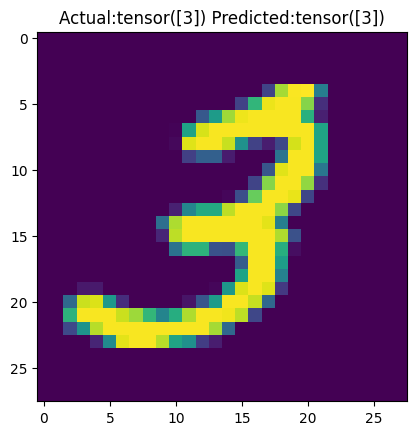

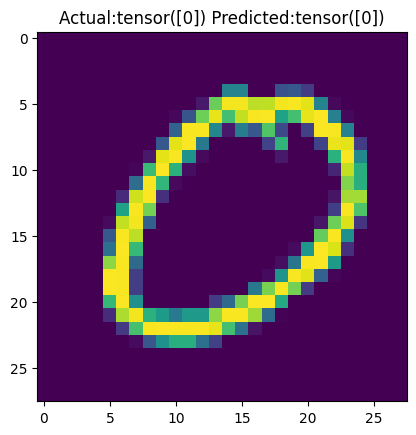

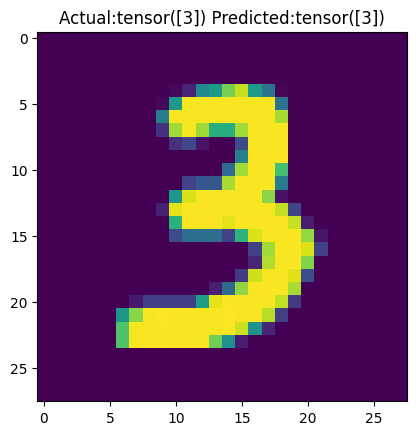

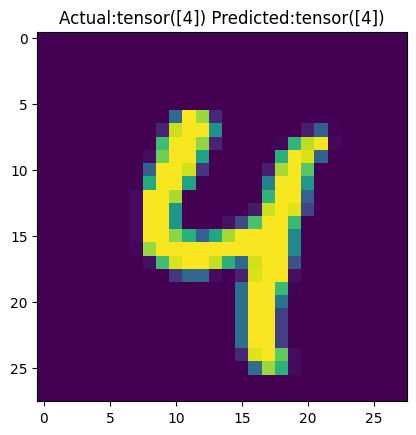

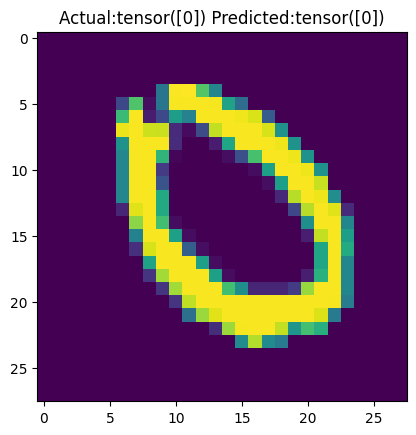

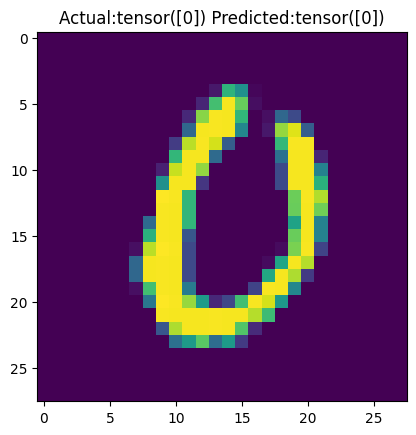

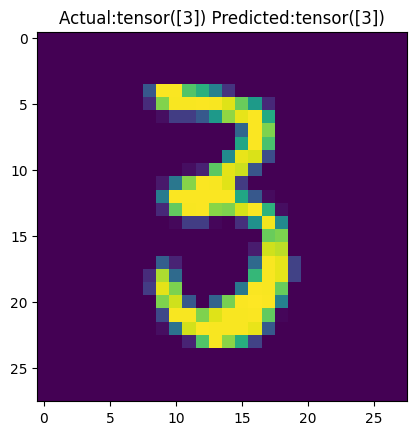

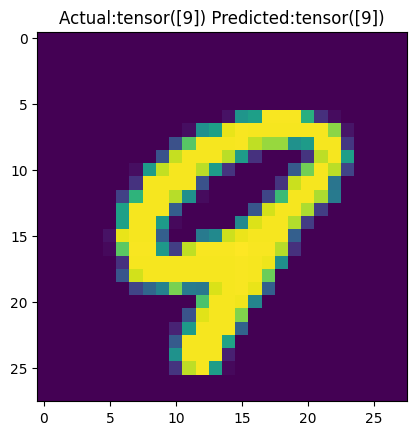

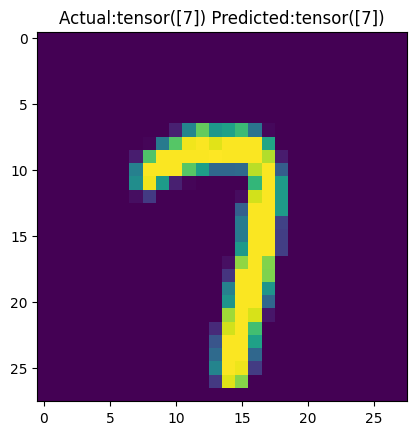

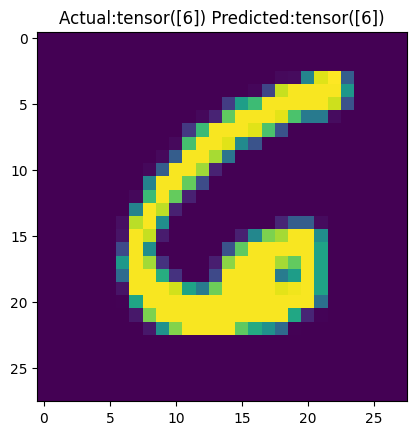

tensor([9923.])


In [122]:
testcorrect = 0

num = 0
with torch.no_grad():
        model.to('cpu').eval()
        for (x, y) in test_loader:
            num+=1
            (x, y) = (x.to('cpu'), y.to('cpu'))
            pred = model(x)
            if num%1000 == 0:
                plt.title('Actual:'+str(y)+' Predicted:'+str(pred.argmax(1)))
                plt.imshow(x.squeeze())
                plt.show()
            #print(pred.argmax(1))
            testcorrect += (pred.argmax(1) == y).type(torch.float)
print(testcorrect)

In [126]:
print('Train Accuracy: '+str(50000*100/50000))
print('Validation Accuracy: '+str(9894*100/10000))
print('Test accuracy: '+str(9923*100/10000))

Train Accuracy: 100.0
Validation Accuracy: 98.94
Test accuracy: 99.23
